In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

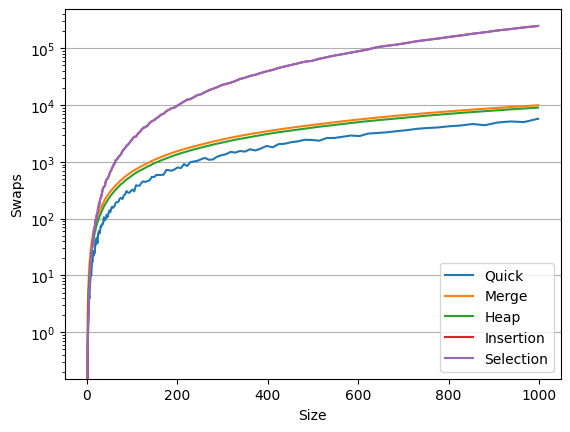

In [3]:
def getDf(name):
    df = pd.read_csv(name)
    df = df[df['size'] < 1000]
    
    df = df.groupby('size').agg(
        comparations_mean=('comparations', 'mean'),
        comparations_std=('comparations', 'std'),
        comparations_var=('comparations', 'var'),
        swaps_mean=('swaps', 'mean'),
        swaps_std=('swaps', 'std'),
        swaps_var=('swaps', 'var'),
        time_mean=('time', 'mean'),
        time_std=('time', 'std'),
        time_var=('time', 'var'),
    ).reset_index()

    df['size_squared'] = df['size'] * df['size']
    df['size_logn'] = df['size'] * np.log2(df['size'])

    return df

def plotDFs(dfs, names, metric='comparations', logScale=True, std=False):
    for df, name in zip(dfs, names):
        
        if std:
            plt.errorbar(
                df['size'],
                df[f"{metric}_mean"],
                yerr=df[f"{metric}_std"],
                capsize=1, # Size of the error bar caps
                linestyle='-',
                ecolor='red',
                label=name,
            )
        else:
            plt.plot(df['size'], df[f"{metric}_mean"], label=name)
        
        plt.ylabel(metric.capitalize())
        plt.xlabel('Size')
        plt.legend()
        plt.grid(axis='y')
        
        if logScale:
            plt.yscale('log')
        # plt.savefig('swaps_squared')

csv_list = ['quick.csv', 'merge.csv', 'heap.csv', 'insertion.csv', 'selection.csv']
names = ['Quick', 'Merge', 'Heap', 'Insertion', 'Selection']
# csv_list = ['insertion.csv']
# names = ['insertion']
# csv_list = ['insertion.csv', 'selection.csv']
# names = ['insertion', 'selection']
# csv_list = ['quick.csv', 'merge.csv', 'heap.csv']
# names = ['quick', 'merge', 'heap']
dfs = []
for csv in csv_list:
    dfs.append(getDf(csv))

plotDFs(dfs, names, metric='swaps', logScale=True)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

def scoreModel(x_train, x_test, y_train, y_test, model_name):
    model = LinearRegression()
    model = model.fit(x_train, y_train)
    return [model_name, r2_score(model.predict(x_test), y_test), model.intercept_, model.coef_, model]

def compareModels(dfs, names, metric='time'):
    results = []
    for df, name in zip(dfs, names):
        results.append([['model', 'accuracy', 'intercept', 'coeficients', 'model']])
        
        x_train, x_test, y_train, y_test = train_test_split(df[['size']], df[f"{metric}_mean"], random_state=42, train_size=0.3)
        results[len(results)-1].append(scoreModel(x_train, x_test, y_train, y_test, 'linear'))
        x_train, x_test, y_train, y_test = train_test_split(df[['size', 'size_logn']], df[f"{metric}_mean"], random_state=42, train_size=0.3)
        results[len(results)-1].append(scoreModel(x_train, x_test, y_train, y_test, 'logarithmic'))
        x_train, x_test, y_train, y_test = train_test_split(df[['size', 'size_squared']], df[f"{metric}_mean"], random_state=42, train_size=0.3)
        results[len(results)-1].append(scoreModel(x_train, x_test, y_train, y_test, 'squared'))

    return results

results = compareModels(dfs, names)
print(results[0])

[['model', 'accuracy', 'intercept', 'coeficients', 'model'], ['linear', 0.9915717728455541, np.float64(-0.002041025658756343), array([6.97764363e-05]), LinearRegression()], ['logarithmic', 0.994897451374522, np.float64(-0.00029090422442628466), array([1.03678009e-05, 6.06900640e-06]), LinearRegression()], ['squared', 0.9942232475250778, np.float64(-0.0010907177252718163), array([6.00820004e-05, 1.19482386e-08]), LinearRegression()]]


/home/edu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/edu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/edu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/edu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/edu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


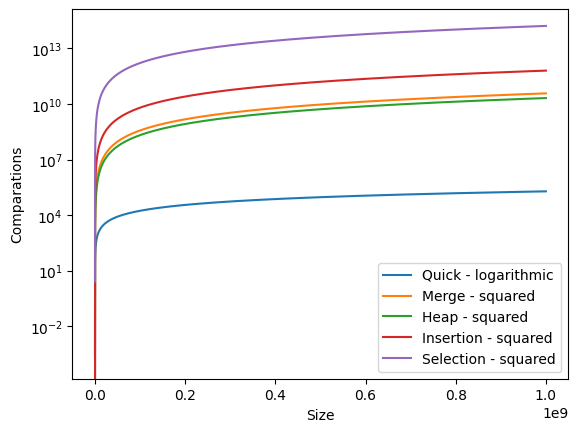

In [14]:
def predict(dfs, names, results, size, metric='comparations', family=False):
    for index, (df, name) in enumerate(zip(dfs, names)):
        best_accuracy = 0
        for index_model, model in enumerate(results[index]):
            if index_model == 0:
                continue
            if model[1] > best_accuracy:
                best_accuracy = model[1]
                best_model = [model[0], model[4], model[3]]

        x = np.arange(1, size, 100000)
        if best_model[0] == 'linear':
            x2 = x
        elif best_model[0] == 'squared':
            x2 = x * x
        elif best_model[0] == 'logarithmic':
            x2 = x * np.log2(x)

        plt.yscale('log')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Size')
        plt.plot(x, best_model[1].predict(np.column_stack([x, x2])), label=f"{name.capitalize()} - {best_model[0]}")
        
        if family:
            plt.plot(x, x2*best_model[2][1]*2, label=f"Above")
            plt.plot(x, x2*best_model[2][1]*0.5, label=f"Under")
        plt.legend()
        if family:
            plt.show()
            
        
predict(dfs, names, results, 1000000000, metric='comparations', family=False)
